### Считывание дата-сета со стоимостями поездок и первичные наблюдения

In [2]:
import pandas as pd
import csv

df = pd.read_csv('files/trip_fare_6_9_15.csv', sep=',', encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df.head()

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,07A0F87F3E065B7013796526962B61FA,D07EB33A97693D232CEF070432EAA9B3,VTS,2013-06-11 15:41:00,CSH,13.0,0,0.5,0,0.00,13.50
1,0DFD8044FC64C1AA272F4B3D7928EEC8,7A45FDCC6A8948A2664AAB5B43C2BBAB,VTS,2013-06-15 18:04:00,CSH,14.5,0,0.5,0,0.00,15.00
2,F36564AB9C6EA3B6373EB0E1680A447A,57BAD78FF0BDEC3A1188EFB287CC4ACD,VTS,2013-06-12 21:55:00,CRD,52.0,0,0.5,0,0.00,52.50
3,40087D340B9D791ADEE055E7AEC4DE12,77DA8EF55B381C08B0A3C7FBDC71D85A,VTS,2013-06-11 18:52:00,CSH,55.0,1,0.5,0,0.00,56.50
4,0FCAD8D2B0D6CAFB4CA81DD5137BE34E,857B6D616015E8C4CEDD1AF17F2C38B2,VTS,2013-06-14 12:56:00,CSH,52.0,0,0.5,0,5.33,57.83


Medallion    - номер такси.

Hack_license - номер лицензии водителя.

Было и так очевидно, но тем не менее стоило перепроверить, в качестве одного из источников можно привести следующую ссылку:
http://www.streetdirectory.com/travel_guide/143929/taxes/hack_license___how_to_get_a_taxi_license_in_new_york_city.html

Далее проверим на уникальность значения medallion и hack_license, а именно, что по одному однозначно можно восстановить другое:

In [10]:
medallion_cnt = {}
hack_license_cnt = {}
medallion_sal = {}
hack_license_sal = {}

unique_hck = True
unique_mdl = True

n = len(df["medallion"])
cc = 0
for i in xrange(n):    
    medallion = df["medallion"][i]
    hack_license = df["hack_license"][i]
    salary = df["total_amount"][i]
    
    mdl_cnt = medallion_cnt.get(medallion, 0)
    hck_cnt = hack_license_cnt.get(hack_license, 0)
    
    if mdl_cnt > hck_cnt:
        unique_mdl = False
    if hck_cnt > mdl_cnt:
        unique_hck = False
    
    medallion_cnt.update({medallion : mdl_cnt + 1})
    hack_license_cnt.update({hack_license : hck_cnt + 1})
    
    medallion_sal.update({medallion : (medallion_sal.get(medallion, 0) + salary)})
    hack_license_sal.update({hack_license : (hack_license_sal.get(hack_license, 0) + salary)})
    
print "Each medallion has the only one hack_license: ", unique_mdl
print "Each medallion has the only one medallion: ", unique_hck

Each medallion has the only one hack_license:  False
Each medallion has the only one medallion:  False


Не лишним будет посмотреть количество различных записей medallion и hack_license в исходном дата-сете:

In [11]:
print "Medallions: ", len(medallion_cnt)
print "Hack_licenses: ", len(hack_license_cnt)

Medallions:  13322
Hack_licenses:  30990


Видно, что количество лицензий примерно в 2.5 раза больше, чем количество транспортных средств, что говорит о том, что будет довольно распространена ситуация, где один автомобиль используется разными водителями (вероятнее всего, здесь будет чёткое разделение на рабочие смены).

### Распределение количества поездок

Построим распределения, наглядно показывающие сооотношение количества поездок и того, сколько водителей (hack_license) и автомобилей (medallion) совершило ровно такое количество поездок:

Populating the interactive namespace from numpy and matplotlib


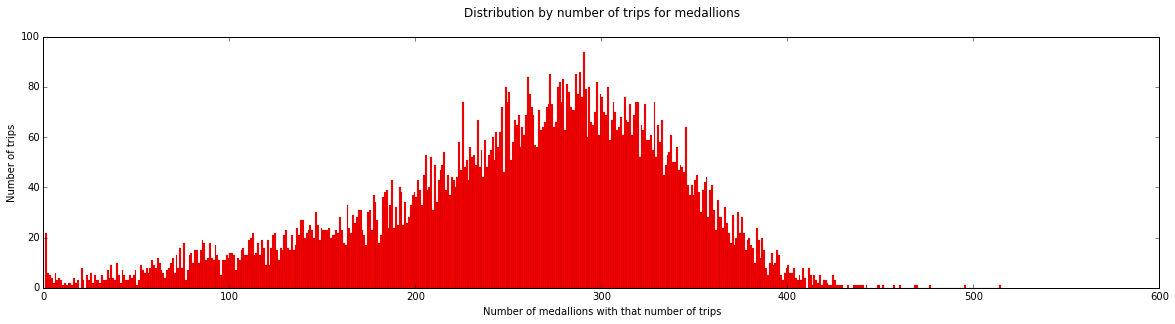

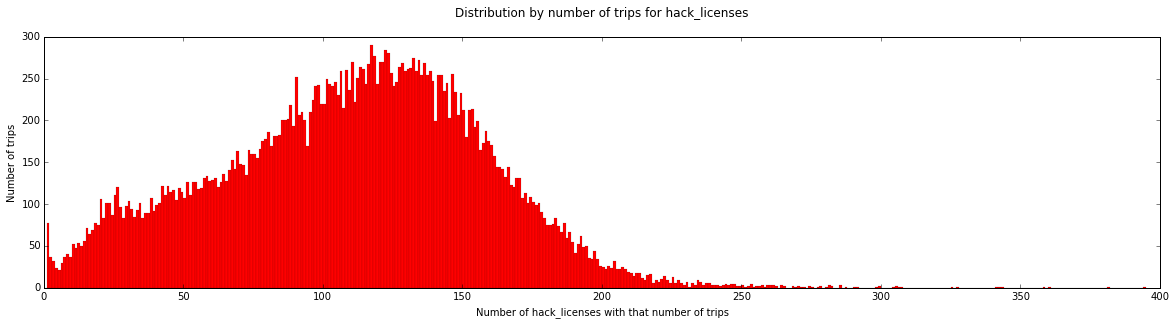

In [12]:
import matplotlib.pylab as pl

%pylab inline

num_mdl = []
num_hck = []

for mdl, cnt in medallion_cnt.items():
    while cnt >= len(num_mdl):
        num_mdl.append(0)
    num_mdl[cnt] += 1
    
for hck, cnt in hack_license_cnt.items():
    while cnt >= len(num_hck):
        num_hck.append(0)
    num_hck[cnt] += 1   

pl.figure(figsize=(20, 4.5))
pl.bar(np.arange(len(num_mdl)), num_mdl, linewidth=0.1, width=1, color='r')
pl.title("Distribution by number of trips for medallions\n")
pl.xlabel('Number of medallions with that number of trips')
pl.ylabel('Number of trips')
pl.show()

pl.figure(figsize=(20, 4.5))
pl.bar(np.arange(len(num_hck)), num_hck, linewidth=0.1, width=1, color='r')
pl.title("Distribution by number of trips for hack_licenses\n")
pl.xlabel('Number of hack_licenses with that number of trips')
pl.ylabel('Number of trips')
pl.show()

Оба графика представляют собой хороший пример нормального распределения Гаусса.

### Распределение средней стоимости поездки, гипотеза об обратной пропорциональности распределения

Теперь исследуем зависимость средней стоимости поездки для водителей (hack_license) в зависимости от количества их поездок. Аналогичное проделаем и с medallion.

Есть подозрение, что размер средней стоимости приблизительно обратно пропорционален количеству поездок (чаще-ближе-меньше, реже-дольше-больше). Чтобы наглядно в этом убедиться построим гистограммы, где для большей корректности будем рассматривать элементы с количеством поездок >= 30:

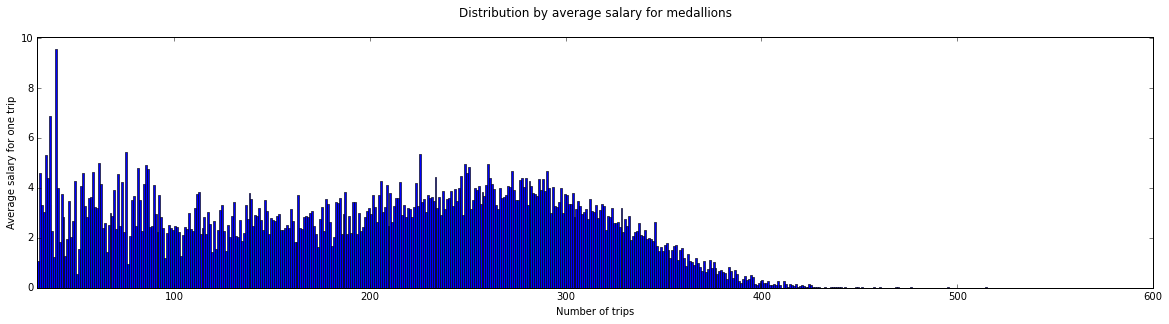

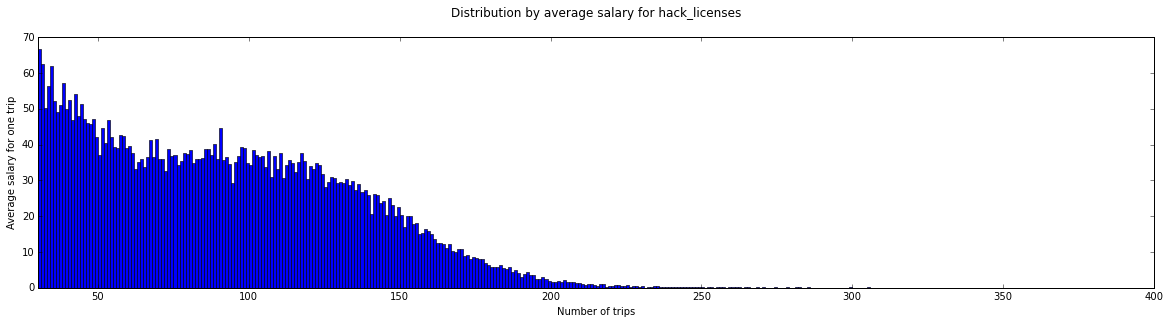

In [69]:
LOW_BOUND = 30

sal_mdl = []
sal_hck = []

for mdl, cnt in medallion_cnt.items():
    while cnt >= len(sal_mdl):
        sal_mdl.append(0)
    sal_mdl[cnt] += 1. * medallion_sal[mdl] / cnt
    
for hck, cnt in hack_license_cnt.items():
    while cnt >= len(sal_hck):
        sal_hck.append(0)
    sal_hck[cnt] += 1. * hack_license_sal[hck]  / cnt 
    
for i in xrange(1, len(sal_mdl)):
    sal_mdl[i] /= i
    
for i in xrange(1, len(sal_hck)):
    sal_hck[i] /= i

pl.figure(figsize=(20, 4.5))
pl.bar(np.arange(len(sal_mdl)), sal_mdl, linewidth=0.6, width=1, color='b')
pl.xlim(xmin=LOW_BOUND)
pl.ylim(ymax=max(sal_mdl[LOW_BOUND:]) * 1.05)
pl.title("Distribution by average salary for medallions\n")
pl.ylabel('Average salary for one trip')
pl.xlabel('Number of trips')
pl.show()

pl.figure(figsize=(20, 4.5))
pl.bar(np.arange(len(sal_hck)), sal_hck, linewidth=0.6, width=1, color='b')
pl.xlim(xmin=LOW_BOUND)
pl.ylim(ymax=max(sal_hck[LOW_BOUND:]) * 1.05)
pl.title("Distribution by average salary for hack_licenses\n")
pl.ylabel('Average salary for one trip')
pl.xlabel('Number of trips')
pl.show()

Если для первого графика выдвинутая теория работает не очень хорошо, то на втором графике гипотеза находит своё подтверждение без всяких нареканий.

### Исследуем столбец под названием "tip_amount" (чаевые)

In [72]:
mdl_tip = {}
hck_tip = {}

for i in xrange(n):
    mdl = df["medallion"][i]
    hck = df["hack_license"][i]
    tip = df["tip_amount"][i]
    
    mdl_tip.update({mdl : (mdl_tip.get(mdl, 0) + tip)})
    hck_tip.update({hck : (hck_tip.get(hck, 0) + tip)})

Здесь и далее под "процентом чаевых" (ПЧ) водителя (водителей) будем понимать величину, равную: 100% * (сумма всех заработанных чаевых водителя (водителей) ) / (суммарная стоимость всех поездок водителя (водителей)).

Условно разобьём процент чаевых на 5 групп:

1) Без чаёвых (ПЧ < 1%)

2) Маленькие чаевые (ПЧ < 5%)

3) Обычные чаевые (ПЧ < 10%)

4) Хорошие чаевые (ПЧ < 20%)

5) Отличные чаевые (ПЧ >= 20%)

Посчитаем количество водителей в каждой группе, чтобы сложить представление о средних чаевых водителя и, возможно, обнаружить каких-нибудь очень везучих таксистов. (в расчёт берутся водители с количеством поездок >= 30):

In [130]:
C = [0.01, 0.05, 0.1, 0.2, 1.01]
L = ["No tip", "Small tip", "Medium tip", "Good tip", "Excellent tip"]

tip_group_cnt = [[], [], [], [], []]
hck_group = {}
for hck, tip in hck_tip.items():
    tip_percent = 1. * tip / hack_license_sal[hck]
    for i, c in enumerate(C):
        if tip_percent < c and LOW_BOUND <= hack_license_cnt[hck]:
            tip_group_cnt[i].append(hck)
            hck_group.update({hck : i})
            break
for i in xrange(len(C)):
    print L[i], ' \t== ', len(tip_group_cnt[i])

No tip  	==  18
Small tip  	==  142
Medium tip  	==  21578
Good tip  	==  7303
Excellent tip  	==  3


Выведем hack_license водителей, процент чаевых которых попал в последнюю группу (>= 20%):

In [131]:
print tip_group_cnt[4]

[u'C506E28673474EAFADCD24511092A2A6', u'E20413EB4C478B7932121B63A3655131', u'1BB2744630C1B3BB9E4F5BC39173048E']


Построим график, где будет отображена зависимость суммы всех заработанных чаевых водителя от суммарной стоимости всех его поездок (каждый цвет соответствует отдельной группе).

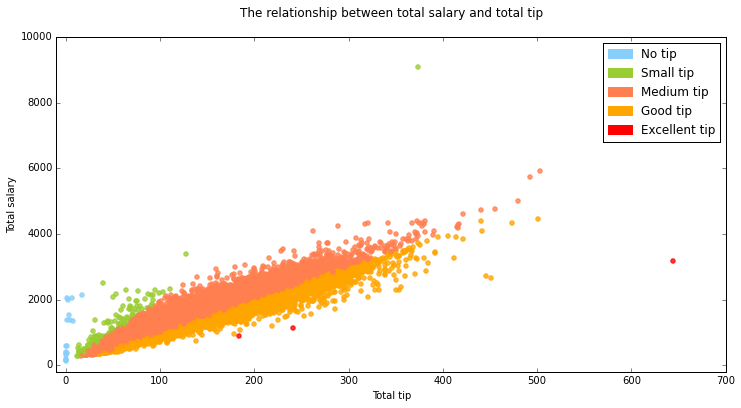

In [163]:
colors = ["lightskyblue", "yellowgreen", "coral", "orange", "red"]
pl.figure(figsize=(12, 6))

for hck, tip in hck_tip.items():
    if hack_license_cnt[hck] >= LOW_BOUND:
        pl.scatter(tip, hack_license_sal[hck], alpha=0.8, color=colors[hck_group[hck]])
        
xlim(xmin=-10)
ylim(ymin=-200)

import matplotlib.patches as mpatches

pl.title("The relationship between total salary and total tip\n")
pl.xlabel('Total tip')
pl.ylabel('Total salary')

patches = []
for i in xrange(len(C)):
    patches.append(mpatches.Patch(color=colors[i], label=L[i]))
plt.legend(handles=patches)

pl.show()

Какие-то очевидные выводы по графику сделать не очень получается, единственное, что можно сказать, что случайно выбранный водитель, который заработал за эту неделю больше 4000 почти наверняка будет принадлежать группе "Обычные чаевые". Вероятно, это во многом обусловлено преобладанием размера этой группы.

Посмотрим, как распределены чаевые по дням недели. Для этого для каждого дня недели посчитаем, в скольки поездках были получены маленькие/обычные/большие/отличные чаевые (для каждой поездки отдельно).

In [179]:
week_day = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['week_day'] = df['pickup_datetime'].apply(lambda t: t.weekday())

In [180]:
df.head()

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,week_day
0,07A0F87F3E065B7013796526962B61FA,D07EB33A97693D232CEF070432EAA9B3,VTS,2013-06-11 15:41:00,CSH,13.0,0,0.5,0,0.00,13.50,1
1,0DFD8044FC64C1AA272F4B3D7928EEC8,7A45FDCC6A8948A2664AAB5B43C2BBAB,VTS,2013-06-15 18:04:00,CSH,14.5,0,0.5,0,0.00,15.00,5
2,F36564AB9C6EA3B6373EB0E1680A447A,57BAD78FF0BDEC3A1188EFB287CC4ACD,VTS,2013-06-12 21:55:00,CRD,52.0,0,0.5,0,0.00,52.50,2
3,40087D340B9D791ADEE055E7AEC4DE12,77DA8EF55B381C08B0A3C7FBDC71D85A,VTS,2013-06-11 18:52:00,CSH,55.0,1,0.5,0,0.00,56.50,1
4,0FCAD8D2B0D6CAFB4CA81DD5137BE34E,857B6D616015E8C4CEDD1AF17F2C38B2,VTS,2013-06-14 12:56:00,CSH,52.0,0,0.5,0,5.33,57.83,4


In [181]:
matr = [[0 for j in xrange(len(C))] for i in xrange(len(week_day))] # C - параметры, разделяющие группы (см. выше)
for i in xrange(n):
    sal = df["total_amount"][i]
    tip = df["tip_amount"][i]
    wday = df["week_day"][i]
    percent = 1. * tip / sal
    group = 0
    for j in xrange(len(C)):
        if percent < C[j]:
            group = j
            break
    matr[wday][group] += 1

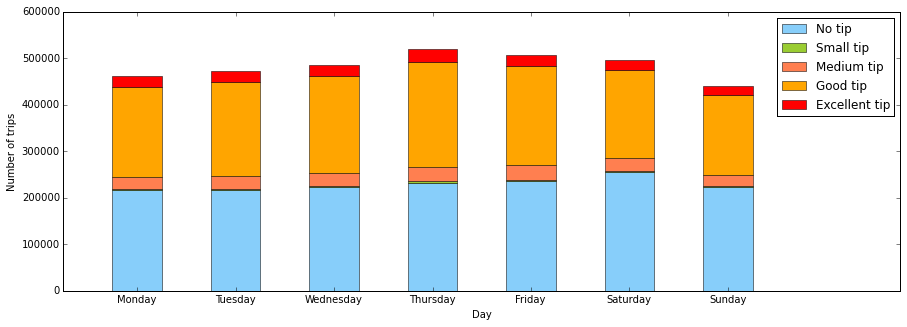

In [252]:
p = []
bottom = [0 for i in xrange(len(week_day))]

pl.figure(figsize=(15, 5))
for i in xrange(len(C)):
    icolumn = [matr[j][i] for j in xrange(len(week_day))]
    p.append(pl.bar(np.arange(len(icolumn)), icolumn, width=0.5, bottom=bottom, color=colors[i], linewidth=0.5))
    bottom = [bottom[j] + icolumn[j] for j in xrange(len(week_day))]
pl.xlabel("Day")
pl.ylabel("Number of trips")
pl.xlim(xmin=-0.5, xmax=8)
pl.xticks(np.arange(len(week_day)) + 0.25, week_day)
pl.legend(p, L)
pl.show()

Как видно из графика, при приблизительно одинаковом числе поездок в каждый из дней недели, соотношение чаевых примерно сохраняется. То есть, например, водителям, вышедшим на работу в воскресенье не стоит расчитывать "сорвать куш" за счёт чаевых.

Однако, есть одно интересное наблюдение: если из предыдущего графика (по водителям) мы видели, что преобладают водители, средний процент чаевых которых принадлежит группе "Обычные чаевые" (5-10%), то здесь, когда мы рассматриваем каждую поездку отдельно, ситуация несколько иная. Сопоставив оба этих графика, можно сказать, что в общем случае у водителя нет какого-то стабильного уровня чаевых, наоборот - в одной поездке он будет получать хорошие чаевые, а в другой - не получит ничего.